In [1]:
# Remember to update your path
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/home/rz14/Documents/QR_Qishi/QishiQR/')

from pathlib import Path

from Backtesting.Vectorized.cross_compare import *

from Utils.lm import gen_strategy, LM_model

import json
import warnings
warnings.filterwarnings(action='ignore')

# ====== Initial Configuration ========

try:
    with open('config.json','r') as f:
        config = json.load(f)
except:
    print("Failed to find the configuration file.")
        
DATA_DIR = config['Tick path']
OUTPUT_DIR = config['Output path']
Strategy_DIR = config['Strategy path']

model_order = config['Max model order']
number_of_states = config['State number']
freq = config['Frequency']
offset = config['Offset']
tca = None

# Build Strategy

In [10]:
ASSET = 'rb'
ASSET_PATH = Path(config['Output path'], ASSET)
ASSET_PATH.mkdir(exist_ok=True, parents=True)

commodity = ASSET
exp_list = ['1601', '1602', '1603', '1604', '1605', '1606', '1607', '1608', '1609', '1610', '1611', '1612', '1701',
                '1702', '1703', '1704', '1705', '1706', '1707', '1708', '1709', '1710', '1711', '1712']



# === Main Routine ===
try:
    strategy = pd.read_csv('../../Strategy/{}_5min_Stra.csv'.format(ASSET))
    slm = strategy[['prior', '0', '1', '2', 'total']].groupby(['prior']).sum().reset_index()
    slm['signal'] = slm.loc[:, '0':'2'].idxmax(axis=1)
except:
    strategy = gen_strategy(commodity, exp_list, number_of_states, model_order, data_root_dir=DATA_DIR, output=OUTPUT_DIR)
    strategy.to_csv('../../Strategy/{}_5min_Stra.csv'.format(ASSET),index=False)
    slm = strategy[['prior', '0', '1', '2', 'total']].groupby(['prior']).sum().reset_index()
    slm['signal'] = slm.loc[:, '0':'2'].idxmax(axis=1)

# Validate

In [31]:
import pandas as pd
from Backtesting.Vectorized.lm_validation import LmValidation

lm_validation = LmValidation(slm, symbol='rb*', data_dir=r'../../Output', valid_dir=r'../../Validation', max_order=8)
lm_validation.run()

# Test one contract

In [33]:
from Backtesting.Vectorized.models import OneContractTest
start = '20161101'
end = '20161231'
max_order=7
test1 = OneContractTest(DATA_DIR, OUTPUT_DIR, slm)
test1.build('ag', '1701', max_order, freq, offset, start, end, 'fixed')
test1.run()

,Annualized Volatility,Average Daily Return,Average Negative Return,Average Positive Return,Average Return per Trade,Largest Losing Trade,Largest Winning Trade,Max Drawdown,Profit Factor,Sharpe Ratio,Total Number of Trades,Total Return,Winning Rate
0,0.136137,0.004497,-0.001424,0.001024,0.000080,-0.016659,0.016641,-0.036845,0.718617,8.257829,2974,1.238330,0.312710
1,0.187102,0.005429,-0.001625,0.001071,0.000130,-0.026554,0.023860,-0.053080,0.658890,7.253798,2206,1.287727,0.483681
2,0.187102,0.005429,-0.001625,0.001071,0.000130,-0.026554,0.023860,-0.053080,0.658890,7.253798,2206,1.287727,0.483681
3,0.169160,0.004958,-0.001586,0.001067,0.000108,-0.026554,0.023860,-0.049712,0.673167,7.327469,2441,1.262778,0.402704
4,0.170500,0.003693,-0.001657,0.001062,0.000087,-0.026554,0.023860,-0.050127,0.641043,5.414711,2259,1.195721,0.413015


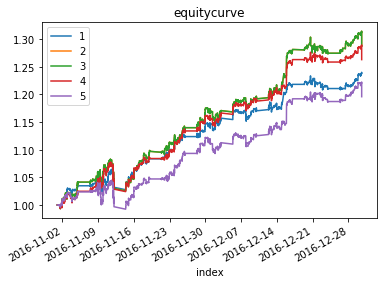

In [34]:
test1.plot()
test1.performance

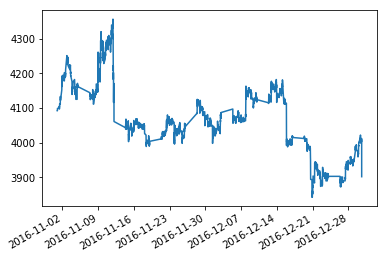

In [14]:
test1.test_data['LastPrice'].plot()

# Compare different contracts

In [35]:
from Backtesting.Vectorized.models import MultiContractTest
start = '20161101'
end = '20161231'
exps=['1701','1702', '1703', '1704', '1705', '1706', '1707', '1708', '1709', '1710', '1711', '1712']
tcas = ['Fixed']*len(exps)

test2 = MultiContractTest(DATA_DIR, OUTPUT_DIR, slm)
test2.build('rb', exps, 4, freq, offset, start, end, tcas)
test2.run()

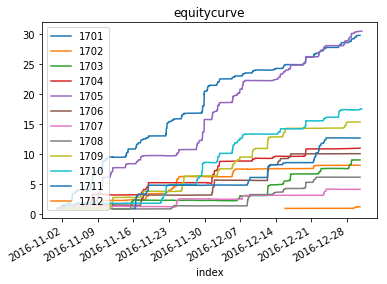

In [36]:
test2.plot()

In [37]:
pd.DataFrame([x.performance for x in test2.ensemble.ensembles])

,Annualized Volatility,Average Daily Return,Average Negative Return,Average Positive Return,Average Return per Trade,Largest Losing Trade,Largest Winning Trade,Max Drawdown,Profit Factor,Sharpe Ratio,Total Number of Trades,Total Return,Winning Rate
0,10.961004,0.640619,-0.001930,0.009379,0.007302,-0.041870,0.075177,-0.011949,4.860830,14.611326,3948,29.827864,0.807244
1,5.387056,0.163297,-0.002658,0.007123,0.003376,-0.028089,0.037568,-0.119556,2.679897,7.578214,2128,8.185070,0.575188
2,5.721598,0.183408,-0.001992,0.010362,0.004332,-0.059070,0.043243,-0.136951,5.201425,8.013838,1863,9.069945,0.471820
3,8.248362,0.227967,-0.001538,0.012157,0.005778,-0.035735,0.042409,-0.037688,7.906208,6.909461,1736,11.030545,0.508065
4,11.727618,0.656242,-0.002186,0.010347,0.007962,-0.040847,0.081178,-0.018563,4.733302,13.989242,3709,30.530887,0.799946
5,7.775978,0.202485,-0.001714,0.012489,0.005288,-0.037481,0.048507,-0.089535,7.286213,6.509965,1723,10.111842,0.461985
6,4.038366,0.072189,-0.001207,0.007383,0.002308,-0.032866,0.032278,-0.068784,6.115888,4.468941,1376,4.176310,0.365552
7,5.344267,0.118163,-0.001170,0.009928,0.004585,-0.051401,0.036815,-0.123539,8.485595,5.527559,1134,6.199173,0.492063
8,9.426565,0.327344,-0.002741,0.010510,0.005969,-0.035035,0.057344,-0.045806,3.834889,8.681415,2413,15.403122,0.629092
9,9.758639,0.376585,-0.002999,0.008635,0.005914,-0.036467,0.079220,-0.059799,2.878865,9.647482,2802,17.569748,0.752677


In [ ]:
test2.plot()
plt.legend(exps)

In [ ]:
test2.performance.index=exps
test2.performance